# Human Activity Recognition Project


## Data pre processing

Import necessary libraries

In [24]:
import numpy as np 
import pandas as pd 
from scipy import signal, stats
import matplotlib.pyplot as plt 
import math
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Global Variables
totaldatasets = 19 # Total number of datasets in file

Load datasets

In [25]:
# Returns an individual dataset as a pandas dataframe. 
# requested_dataSet is the number of the selected dataset, from 1 to 19
# If the number is outside the range of 1 to 19, function returns dataset 1
def getDataset(requested_dataSet):
    if requested_dataSet < 1 or requested_dataSet > totaldatasets:
        requested_dataSet = 1
    dataSet = pd.read_csv('daliac/dataset_'+str(requested_dataSet)+'.txt', sep=',', header=None)
    return dataSet

# Returns all datasets as a list of dataframes
def getAllDatasets():
    dataSets = []
    for n in range(1, totaldatasets + 1):
        dataSets.append(getDataset(n))
    return dataSets

Class dataSets stores imported data sets in an array of dataframes

In [26]:
# A class for handling data 
class dataSets:
    #Constants for activities
    SITTING = 1
    LYING = 2
    STANDING = 3
    WASHINGDISHES = 4 
    VACUUMING = 5 
    SWEEPING = 6 
    WALKING = 7 
    ASCENDSTAIRS = 8
    DESCENDSTAIRS = 9  
    TREADMILLRUN = 10
    CYCLE50W = 11
    CYCLE100W = 12
    ROPEJUMP = 13
    
    #Constants for sensors.
    WRIST_ACCELEROMETER = 0
    WRIST_GYROSCOPE = 3
    CHEST_ACCELEROMETER = 6
    CHEST_GYROSCOPE = 9
    HIP_ACCELEROMETER = 12
    HIP_GYROSCOPE = 15
    ANKLE_ACCELEROMETER = 18
    ANKLE_GYROSCOPE = 21
    
    def __init__(self, dataSet_collection):
        self.dataSet_collection = dataSet_collection
    
    def getSubjectActivity(self, subject, activity):
        return self.dataSet_collection[subject][self.dataSet_collection[subject][24] == activity].values
    
    def getActivitySensor(self, subject, activity, sensor):
        return self.getSubjectActivity(subject, activity)[:, sensor:sensor+3]
    


Signal processing/ Data filtration

In [27]:
# filters data from a given data set.
# Optional parmeter filter_cutoff
# Optional parameters numerator and denominator allow for use of custom filter.
# Otherwise defaults to lowpass butterworth filter
def remove_noise(data_set, filter_cutoff = None,
                 numerator = signal.butter(4, 0.04, 'low', analog = False)[0],
                 denominator = signal.butter(4, 0.04, 'low', analog = False)[1]):
    for column in range(len(data_set[0][:filter_cutoff])):
        data_set[:, column] = signal.lfilter(numerator, denominator, data_set[:, column])
    return data_set


Data visualisation

In [28]:
def visualise_data(plot_list):
    if isinstance(plot_list, np.ndarray):
        plot_list = [plot_list]
    elif len(plot_list) <= 0:
        print('Please create a list of dataframes you wish to plot')
        return
    
    if len(plot_list) == 1:
        plt.plot(plot_list[0])
    else:
        plot_space, grid_axes = plt.subplots(
            nrows=( int(math.ceil(len(plot_list) / 2)) ), ncols=2, sharex=False, sharey=False)
        plot_space.set_size_inches(14,  6 *  int(math.ceil(len(plot_list) / 2)))
        
        if len(plot_list) == 2:
            for index, value in enumerate(plot_list):
                grid_axes[index].plot(value)
        else:
            row = 0
            for index, value in enumerate(plot_list):
                if ( index != 0 and index % 2 == 0 ):
                    row = row + 1
                grid_axes[row][index % 2].plot(value)
    plt.show()

## Implementation

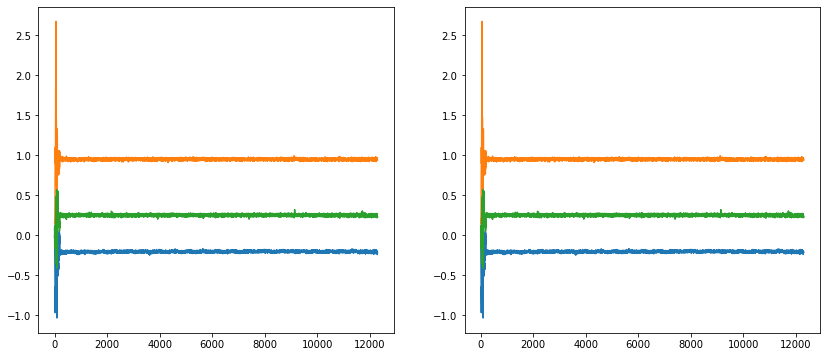

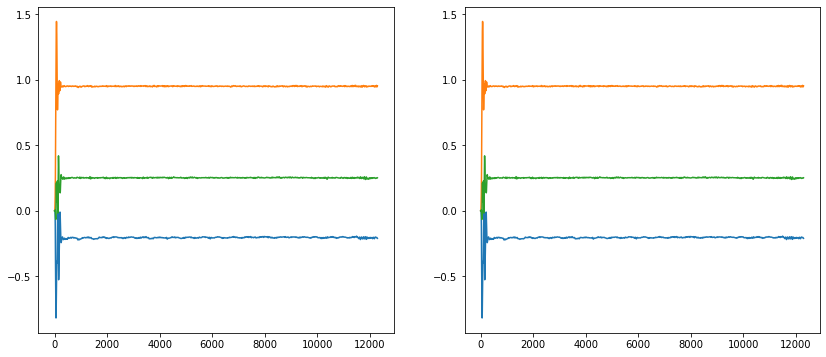

In [29]:
#Get all datasets
HAR_dataset = dataSets(getAllDatasets())

#Visualise unfiltered data from wrist Accelerometer and Gyroscope
visualise_data([HAR_dataset.getActivitySensor(0, dataSets.SITTING, dataSets.WRIST_ACCELEROMETER),
               HAR_dataset.getActivitySensor(0, dataSets.SITTING, dataSets.WRIST_GYROSCOPE)])

#Visualise filtered data from wrist Accelerometer and Gyroscope
visualise_data([remove_noise(HAR_dataset.getActivitySensor(0, dataSets.SITTING, dataSets.WRIST_ACCELEROMETER)),
               remove_noise(HAR_dataset.getActivitySensor(0, dataSets.SITTING, dataSets.WRIST_GYROSCOPE))])

## Feature Processing

In [32]:
# Extracts features from time segments of a dataset
# Accepts flexible number of feature extraction techniques
def time_series_features(time_series, time_window = 1000, total_sensors = 3, select_features = [np.min, np.max, np.mean]):
    feature_set = []

    total_segments = len(time_series) // time_window + 1
   
    for segment in range(total_segments):
        if segment < total_segments - 1:
            sample_data = time_series[time_window*segment: time_window*(segment+1), :]
        else:
            sample_data = time_series[time_window*segment:,:]
        feature_sample = []
        for sensor in range(total_sensors):
            for feature in select_features:
                feature_sample.append(feature(sample_data[:, sensor]))
        feature_sample.append(sample_data[0, -1])
        feature_set.append(feature_sample)
    
    return feature_set

def convert_to_csv(two_dimension_array, filepath):
    pd.DataFrame(two_dimension_array).to_csv(filepath, index=None, header=None)
    
# Writes training and testing datasets to csv files.
def prepare_training_sets(dataset_collection, 
                                training_ratio = 0.8, 
                                time_window = 1000, 
                                total_sensors = 3, 
                                features = [np.min, np.max, np.mean]):
    training_feature_set = []
    testing_feature_set = []
    # deal with each dataset file
    for participant in range(totaldatasets):
        for activity in range(1, 14):
            activity_data = remove_noise(dataset_collection.getSubjectActivity(participant, activity), filter_cutoff = 24)

            training_len = math.floor(len(activity_data) * training_ratio)
            training_data = activity_data[:training_len, :]
            testing_data = activity_data[training_len:, :]

            training_feature_set = training_feature_set + \
                                   time_series_features(training_data, time_window, total_sensors, features)
            testing_feature_set = testing_feature_set + \
                                  time_series_features(testing_data, time_window, total_sensors, features)

    convert_to_csv(training_feature_set, 'training_data.csv')
    convert_to_csv(testing_feature_set, 'testing_data.csv')

## Implementation

In [33]:
# Create Training and Testing csv files
prepare_training_sets(HAR_dataset, total_sensors = 24, features = [np.min, np.max, np.mean, np.std, stats.skew, stats.kurtosis])

## Machine Learning 

In [35]:
# Generic function for reading a training feature set
# Outputs labels and values
def get_training_data(filepath):
    training_dataset = pd.read_csv(filepath, header=None)
    # Labels should start from 0 in sklearn
    data_labels = training_dataset[len(training_dataset.columns) - 1].values
    data_labels = data_labels - 1
    training_dataset = training_dataset.drop([len(training_dataset.columns) - 1], axis=1)
    data_features = training_dataset.values
    return data_labels, data_features

# Returns data from both training and testing sets
# Outputs training and testing data and labels
def get_normalized_training_data():
    training_label, training_data = get_training_data('training_data.csv')
    testing_label, testing_data = get_training_data('testing_data.csv')

    scaler = preprocessing.StandardScaler().fit(training_data)
    training_data = scaler.transform(training_data)
    testing_data = scaler.transform(testing_data)
    
    return training_label, training_data, testing_label, testing_data

# Prints accuracy metrics for tests
def print_accuracy(test_labels, predicted_labels):
    print('Accuracy: ', accuracy_score(test_labels, predicted_labels))
    print(confusion_matrix(test_labels, predicted_labels))

def run_k_nearest_neighbor(train_label, train_data, test_label, test_data, nearest_neighbors = 3):
    knn = KNeighborsClassifier(n_neighbors = nearest_neighbors)
    knn.fit(train_data, train_label)

    predict_label = knn.predict(test_data)
    print_accuracy(test_label, predict_label)

def run_support_vector_machine(train_label, train_data, test_label, test_data):
    
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-1,1e-2, 1e-3, 1e-4],
                     'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 100]},
                    {'kernel': ['linear'], 'C': [1e-3, 1e-2, 1e-1, 1, 10, 100]}]
    acc_scorer = make_scorer(accuracy_score)
    grid_obj  = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring=acc_scorer)
    grid_obj  = grid_obj .fit(train_data, train_label)
    clf = grid_obj.best_estimator_
    print('best clf:', clf)
    clf.fit(train_data, train_label)
    predict_label = clf.predict(test_data)
    print_accuracy(test_label, predict_label)


## Implementation

In [36]:
# Read Training and testing CSV files
ytrain, xtrain, ytest, xtest = get_normalized_training_data()

# Train KNN classifier
run_k_nearest_neighbor(ytrain, xtrain, ytest, xtest, 3)

Accuracy:  0.9126679462571977
[[ 52   1   2   2   0   0   0   0   0   0   0   0   0]
 [  0  57   0   0   0   0   0   0   0   0   0   0   0]
 [  3   0  52   2   0   0   0   0   0   0   0   0   0]
 [  0   0   3  96   0   0   0   0   0   0   0   0   0]
 [  0   0   1   2  49   5   0   0   0   0   0   0   0]
 [  0   0   0   2  22  58   1   2   0   0   0   0   0]
 [  0   0   0   1   5   1 212   0   0   0   0   0   0]
 [  0   0   1   0   0   0   1  36   0   0   0   1   0]
 [  0   0   0   0   0   1   1   0  36   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  96   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0  86  13   0]
 [  0   0   0   0   0   0   1   0   1   0  14  84   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0  37]]


In [37]:
# Train SVM Classifier
run_support_vector_machine(ytrain, xtrain, ytest, xtest)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best clf: SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy:  0.9452975047984645
[[ 56   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0  57   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  57   0   0   0   0   0   0   0   0   0   0]
 [  0   0   2  95   1   1   0   0   0   0   0   0   0]
 [  0   0   1   2  48   6   0   0   0   0   0   0   0]
 [  0   0   0   1   8  76   0   0   0   0   0   0   0]
 [  0   0   2   0   4   2 210   0   1   0   0   0   0]
 [  0   0   1   0   0   0   0  38   0   0   0   0   0]
 [  1   0   0   0   0   1   0   0  36   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0  95   0   0   0]
 [  0   0   1   0   0   2   0   0   0   0  88   9   0]
 [  0   0   1   0   0   1   0   0   0   0   6  92   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0  37]]
